<a href="https://colab.research.google.com/github/Hitchhiker90/reinforcement-learning-notebooks/blob/main/RL1_k_armed_Bandit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table align="center" width="100%"> 
    <tr>
        <th>Reinforcement Learning (examples and exercises from Sutton and Barto, 2018)</th>
    </tr>
    <tr>
        <td align="center">by Łukasz Przybyła (<a href="https://lukaszp.dev">Website</a>, <a href="https://github.com/hitchhiker90">GitHub</a>)</td>
    </tr>
    <tr>
        <td><b>CHAPTER 2. MULTI-ARMED BANDITS</b></td>
    </tr>
    <tr>
        <td><b>1. k-armed Bandit</b></td>
    </tr>
    <tr>
        <td><a href="https://colab.research.google.com/drive/1YmLK3q7OmGlglPJsTLz3PazxcMlOsVzJ?usp=sharing">2. Next Topic</a></td>
    </tr>
    <tr>
        <td><b>CHAPTER 3. FINITE MARKOV DECISION PROCESSES<b></td>
    </tr>
</table>

# <b>k-armed Bandit</b>

In [ ]:
import random
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
        
# Global matplotlib settings
matplotlib.rcParams.update({'font.size': 13})

## Testbeds

### Stationary bandit

A $k$-armed test-bed with fixed weights initialised randomly from normal distribution determined by average and variance given as parameters. Reward for each action is also taken randomly from normal distribution with specified variance.

In [ ]:
class Bandit():

    def __init__(self, actions, value_mean, value_variance, reward_variance):
        """
        Initialise an instance of a stationary bandit problem.

        Arguments:
        actions: number of actions, k (int)
        value_mean: mean of true action value distribution (number)
        value_variance: variance of true action value distribution (number)
        reward_variance: variance of reward distribution around action values (number)
        """
        
        self.action_values = self.generate_action_values(actions, value_mean, value_variance)
        self.reward_variance = reward_variance

    def generate_action_values(self, count, mean, variance):
        """
        Return a list of values for given number of actions taken
        from normal distribution defined by provided mean and variance

        Arguments:
        count: number of available actions (int)
        mean: the mean of the action value distribution (number)
        variance: the variance of the action value distribution (number)
        """

        return np.random.normal(mean, variance, count)

    def get_reward(self, action):
        """
        Return a reward for the specified action taken from normal distribution.
        
        Arguments:
        action: index of selected action (int)
        """

        return random.gauss(self.action_values[action], self.reward_variance)

### Non-stationary bandit

A modified version of the $k$-armed testbed in which all the true action values start out equal and then take independent random walks by adding a normally distributed increment with mean zero and given standard deviation on each step.


In [ ]:
class NonStationaryBandit(Bandit):

    def __init__(self, actions, value_mean, value_variance, reward_variance, 
                 step_deviation):
        """
        Initialise an instance of a non-stationary bandit problem.

        Arguments:
        actions: number of actions, k (int)
        value_mean: the mean of the action value distribution (number)
        value_variance: the variance of the action value distribution (number)
        reward_variance: variance of reward distribution around action values (number)
        step_deviation: std deviation of the normal distribution from which
            increment value is taken at each step (number)
        """
        
        super().__init__(actions, value_mean, value_variance, reward_variance)
        self.step_deviation = step_deviation

    def adjust_action_values(self):
        """
        Adjust all action value by a random increment from normal distribution
        with mean zero and std deviation specified as instance attribute.
        """
        
        self.action_values += np.random.normal(0, self.step_deviation, actions)

    def get_reward(self, action):
        """
        Return a reward for the specified action taken from normal distribution.
        Then adjust the action values.

        Arguments:
        action: index of selected action (int)
        """

        reward = random.gauss(self.action_values[action], self.reward_variance)
        self.adjust_action_values()
        return reward 

### Bandit with predefined action values

A (potentially) non-stationary k-armed testbed in which the true action values at each time-step are predefined and given as an argument.


In [ ]:
class FixedBandit():

    def __init__(self, action_values, reward_variance):
        """
        Initialise an instance of a bandit problem with fixed true values
        at each time-step.

        Arguments:
        action_values: a list of action values for each time-step (list)
        reward_variance: variance of reward distribution around action values (number)
        """
        
        self.action_values = action_values
        self.reward_variance = reward_variance
        self.time_step = 0

    def get_reward(self, action):
        """
        Return a reward for the specified action at the specified step
        taken from the predefined sequence.

        Arguments:
        action: index of selected action (int)
        """

        reward = random.gauss(self.action_values[self.time_step][action], self.reward_variance)
        self.time_step += 1
        return reward

## Agents

### Sample-average agent - incremental implementation

The agent starts with action-value estimates intialised as zeros, and updates the relevant estimate after each action using the **sample-average** method, that is with a step-size inversely proportional to the number of times that the action has been selected ($n$):

$$Q_{n+1}=Q_n+\frac{1}{n}\biggl[R_n - Q_n\biggr]$$

This method values all experiences equally.

In [ ]:
class SampleAvgAgent():

    typeLabel='sample-avg.'

    def __init__(self, epsilon, action_count, *args):
        self.epsilon = epsilon
        self.action_counter = np.zeros(action_count)
        self.action_value_estimates = np.zeros(action_count)

    def play(self, bandit):
        """
        Play a single iteration of the provided bandit problem.

        Arguments:
        bandit: a k-armed bandit with fixed reward distribution (Bandit)
        """

        if random.random() >= self.epsilon:
            next_action = np.argmax(self.action_value_estimates)
        else:
            next_action = random.randint(0, len(self.action_value_estimates) - 1)
        
        reward = bandit.get_reward(next_action)
        self.action_counter[next_action] += 1
        self.action_value_estimates[next_action] += \
            (reward - self.action_value_estimates[next_action]) / self.action_counter[next_action]

        return next_action, reward

### Constant step-size agent

The agent starts with action-value estimates intialised as zeros, and updates them using an analogous equation, but with a **fixed step-size $\alpha$** given as parameter:

$$Q_{n+1}=Q_n+\alpha\biggl[R_n - Q_n\biggr]$$

This method gives the most weight to most recent experiences, with the weight of each past reward decaying exponentially.

In [ ]:
class ConstantAlphaAgent():

    typeLabel='const-α'

    def __init__(self, epsilon, action_count, *args):
        self.alpha = args[0]
        self.epsilon = epsilon
        self.action_counter = np.zeros(action_count)
        self.action_value_estimates = np.zeros(action_count)

    def play(self, bandit):
        """
        Play a single iteration of the provided bandit problem.

        Arguments:
        bandit: a k-armed bandit with fixed reward distribution (Bandit)
        """

        if random.random() >= self.epsilon:
            next_action = np.argmax(self.action_value_estimates)
        else:
            next_action = random.randint(0, len(self.action_value_estimates) - 1)
        
        reward = bandit.get_reward(next_action)
        self.action_counter[next_action] += 1
        self.action_value_estimates[next_action] += \
            (reward - self.action_value_estimates[next_action]) * alpha

        return next_action, reward

## Helpers

In [ ]:
def execute_stationary_run(action_count, value_mean, value_variance, reward_variance, time_steps, agent):
    """
    Execute a complete run with given parameters and agent.
    Initialise a stationary bandit, iterate through steps.

    Arguments:
    action_count: number of available actions (int)
    value_mean: the mean of the action value distribution (number)
    value_variance: the variance of the action value distribution (number)
    time_steps: number of consecutive time steps in a single run (int)
    agent: an agent object with a specified policy
    """    
    
    bandit = Bandit(action_count, value_mean, value_variance, reward_variance)
    best_action = np.argmax(bandit.action_values)
        
    rewards = np.empty(time_steps)
    optimum_actions = np.empty(time_steps)

    for step in range(time_steps):
        step_action, step_reward = agent.play(bandit)
        rewards[step] = step_reward
        optimum_actions[step] = (step_action == best_action)

    return rewards, optimum_actions

In [ ]:
def execute_non_stationary_run(action_count, value_mean, value_variance, reward_variance, time_steps, agent, step_deviation):
    """
    Execute a complete run with given parameters and agent.
    Initialise a non-stationary bandit, iterate through steps.

    Arguments:
    action_count: number of available actions (int)
    init_value: initial true value of all actions (number)
    reward_variance: variance of reward distribution around action values (number)
    time_steps: number of consecutive time steps in a single run (int)
    agent: an agent object with a specified policy
    step_deviation: std deviation of the normal distribution from which
        increment value is taken at each step (number)
    """    
    
    bandit = NonStationaryBandit(action_count, value_mean, value_variance, reward_variance, step_deviation)

    rewards = np.empty(time_steps)
    optimum_actions = np.empty(time_steps)

    for step in range(time_steps):
        
        # Best action may change during game, so needs to be re-checked
        best_action = np.argmax(bandit.action_values)

        step_action, step_reward = agent.play(bandit)
        rewards[step] = step_reward
        optimum_actions[step] = (step_action == best_action)

    return rewards, optimum_actions

In [ ]:
def execute_fixed_run(action_values, reward_variance, agent):
    """
    Execute a complete run with given parameters and agent.
    Initialise a bandit, iterate through steps.

    Arguments:
    action_values: a list of action values for each time-step (list)
    reward_variance: variance of reward distribution around action values (number)
    agent: an agent object with a specified policy 
    """    
    
    bandit = FixedBandit(action_values, reward_variance)

    rewards = np.empty(time_steps)
    optimum_actions = np.empty(time_steps)

    for step in range(len(action_values)):
        
        # Best action may change during game, so needs to be re-checked
        best_action = np.argmax(bandit.action_values[step])

        step_action, step_reward = agent.play(bandit)
        rewards[step] = step_reward
        optimum_actions[step] = (step_action == best_action)

    return rewards, optimum_actions

In [ ]:
def plot_sample_rewards(actions, value_mean, value_variance, reward_variance):
    """
    Generate a plot of a sample reward distribution under given parameters

    Arguments:
    actions: number of available actions (int)
    value_mean: the mean of the action value distribution (number)
    value_variance: the variance of the action value distribution (number)
    reward_variance: the variance of the reward distribution (number)
    """

    bandit = Bandit(actions, value_mean, value_variance, reward_variance)
    action_values = bandit.generate_action_values(actions, value_mean, value_variance)

    # Generate 2000 sample rewards for each action from normal distribution
    reward_values = [[bandit.get_reward(action) for i in range(2000)] 
                    for action 
                    in range(actions)]

    # Create a violin plot of reward distributions
    plt.figure(figsize=(10,5))
    plt.title("Sample reward distribution across actions")
    plt.xlabel("Action")
    plt.xlim(0, actions + 1)
    plt.xticks(range(1, actions + 1))
    plt.ylabel("Reward distribution")
    value_range = 2 * (value_variance + reward_variance)
    plt.ylim(-value_range, value_range)

    plt.violinplot(reward_values, showextrema=False, showmeans=True)
    plt.plot([0, actions + 1], [0, 0], color="black", linestyle="--", linewidth=1)

    plt.show()

## Tests

### Sample-average method on a stationary problem

A reproduction of the 10-armed testbed analysis from *Chapter 2* of **Sutton and Barto**, showcasing the advantage of random exploration over a purely greedy approach.

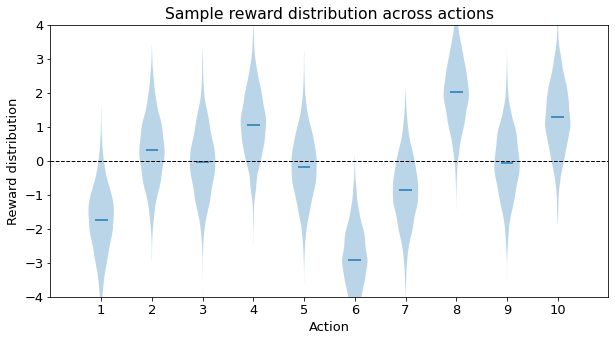

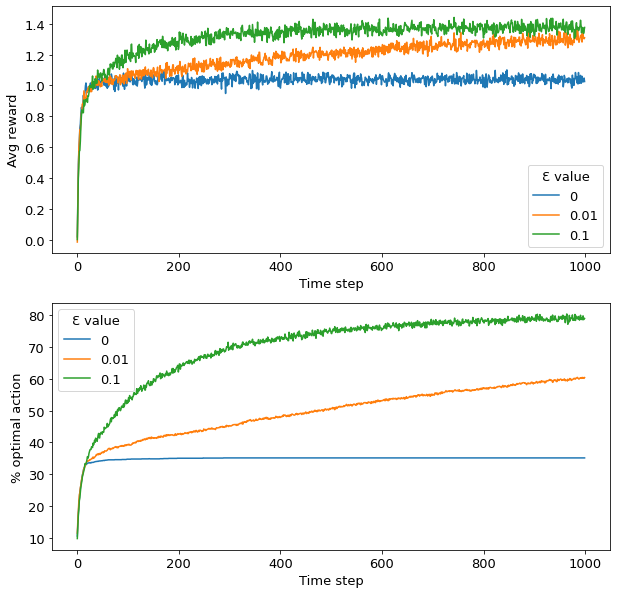

In [ ]:
# Testbed parameters
actions = 10
value_mean = 0
value_variance = 1
reward_variance = 1
time_steps = 1000
runs = 2000
epsilon_values = [0, 0.01, 0.1]

# Show a plot of a sample reward distribution under given parameters
plot_sample_rewards(actions, value_mean, value_variance, reward_variance)

plt.figure(figsize=(10,10))
fig1 = plt.subplot(2, 1, 1)
plt.xlabel("Time step")
plt.ylabel("Avg reward")

fig2 = plt.subplot(2, 1, 2)
plt.xlabel("Time step")
plt.ylabel("% optimal action")

# For each policy, perform the defined number of runs:
for epsilon in epsilon_values:
    
    results = np.empty((runs, time_steps))
    optimum_decisions = np.empty((runs, time_steps))
    
    for run in range(runs):
        agent = SampleAvgAgent(epsilon, actions)
        results[run], optimum_decisions[run] = execute_stationary_run(actions,
                                                                      value_mean,
                                                                      value_variance,
                                                                      reward_variance,
                                                                      time_steps,
                                                                      agent)

    avg_rewards = np.average(results, axis=0)
    optimum_percentages = np.count_nonzero(optimum_decisions, axis=0) / runs * 100
    
    fig1.plot(avg_rewards, label=str(epsilon))
    fig2.plot(optimum_percentages, label=str(epsilon))
    
fig1.legend(title='Ɛ value')
fig2.legend(title='Ɛ value')
plt.show()

### Sample-average and fixed time-step methods on a non-stationary problem

> Exercise 2.5 (Sutton and Barto, 2018)
>
> *Design and conduct an experiment to demonstrate the
difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the $q_*(a)$ start out equal and then take independent random walks (say by adding a normally distributed increment with mean zero and standard deviation 0.01 to all the $q_*(a)$ on each step). Prepare plots like Figure 2.2 for an action-value method using sample averages, incrementally computed, and another action-value method using a constant step-size parameter, $\alpha$ = 0.1. Use $\varepsilon$ = 0.1 and longer runs, say of 10,000 steps.*

#### Average performance over a batch of random scenarios

This is essentially a recreation of the test above, but with a non-stationary bandit problem, and comparing different update rules (**sample-average** vs. **constant step-size**).

>*Allow a few minutes for the algorithm to run.*

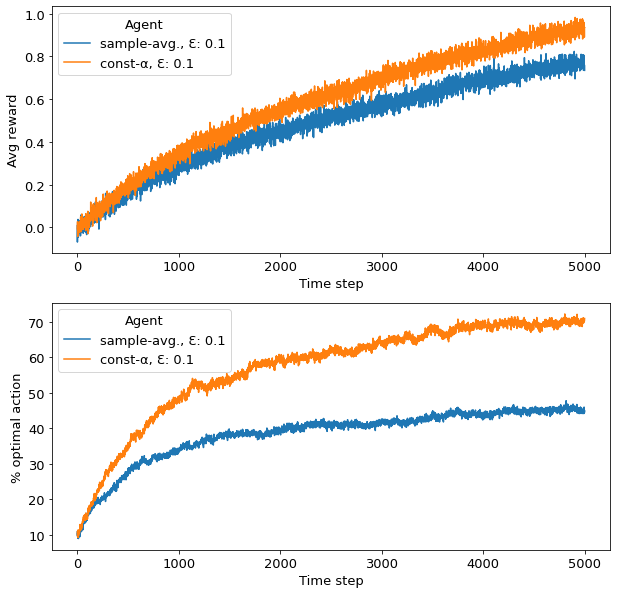

In [ ]:
# Testbed parameters
actions = 10
value_mean = 0
value_variance = 0
step_deviation = 0.01
reward_variance = 1
time_steps = 5000
runs = 2000
alpha = 0.1
epsilon_values = [0.1]

plt.figure(figsize=(10,10))
fig1 = plt.subplot(2, 1, 1)
plt.xlabel("Time step")
plt.ylabel("Avg reward")

fig2 = plt.subplot(2, 1, 2)
plt.xlabel("Time step")
plt.ylabel("% optimal action")

# For each combination of agent type and policy, perform the defined number of runs:
for agent_type in [SampleAvgAgent, ConstantAlphaAgent]:
    for epsilon in epsilon_values:
        
        results = np.empty((runs, time_steps))
        optimum_decisions = np.empty((runs, time_steps))
        for run in range(runs):
            agent = agent_type(epsilon, actions, alpha)
            results[run], optimum_decisions[run] = execute_non_stationary_run(actions,
                                                                              value_mean,
                                                                              value_variance,
                                                                              reward_variance,
                                                                              time_steps, 
                                                                              agent,
                                                                              step_deviation)

        avg_rewards = np.average(results, axis=0)
        optimum_percentages = np.count_nonzero(optimum_decisions, axis=0) / runs * 100
            
        fig1.plot(avg_rewards, label=agent_type.typeLabel + ", Ɛ: " + str(epsilon))
        fig2.plot(optimum_percentages[1:], label=agent_type.typeLabel + ", Ɛ: " + str(epsilon))
    
fig1.legend(title='Agent')
fig2.legend(title='Agent')
plt.show()

#### Average performance on a fixed scenario

The graphs above illustrate the general difference in performance between the two algorithms, however fail to give insight about the reason for the difference. To try and inspect the reason behind the sample-average underperforming, we can test the algorithms against a single fixed problem and visualise their average rewards relative to each other and the maximum possible.

>*Allow a few minutes for the algorithm to run.*

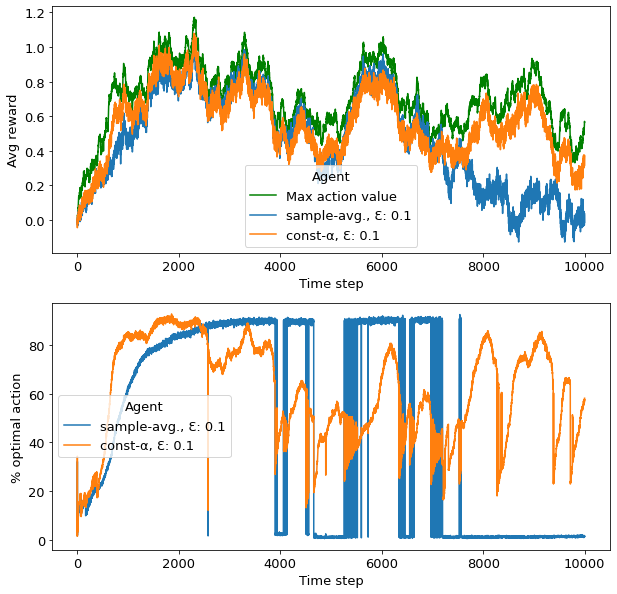

In [ ]:
# Testbed parameters
actions = 10
value_mean = 0
value_variance = 0
step_deviation = 0.01
reward_variance = 1
time_steps = 10000
runs = 2000
alpha = 0.1
epsilon_values = [0.1]

plt.figure(figsize=(10,10))
fig1 = plt.subplot(2, 1, 1)
plt.xlabel("Time step")
plt.ylabel("Avg reward")

fig2 = plt.subplot(2, 1, 2)
plt.xlabel("Time step")
plt.ylabel("% optimal action")

# Generate a sequence of action values
action_values = []
action_values.append([random.gauss(value_mean, value_variance) for k in range(actions)])

for n in range(1, time_steps):
    action_values.append([action_values[n-1][k] + random.gauss(0, step_deviation)
                            for k in range(actions)])
    
action_values = np.array(action_values)

# Plot the maximum possible reward at each step
fig1.plot([max(action_values[n]) for n in range(time_steps)], 
          label="Max action value", 
          color="green")

# For each combination of agent type and policy, perform the defined number of runs:
for agent_type in [SampleAvgAgent, ConstantAlphaAgent]:
    for epsilon in epsilon_values:
        
        results = np.empty((runs, time_steps))
        optimum_decisions = np.empty((runs, time_steps))
        
        for run in range(runs):
            agent = agent_type(epsilon, actions, alpha)
            results[run], optimum_decisions[run] = execute_fixed_run(action_values,
                                                                     reward_variance,
                                                                     agent)

        avg_rewards = np.average(results, axis=0)
        optimum_percentages = np.count_nonzero(optimum_decisions, axis=0) / runs * 100
            
        fig1.plot(avg_rewards, label=agent_type.typeLabel + ", Ɛ: " + str(epsilon))
        fig2.plot(optimum_percentages[1:], label=agent_type.typeLabel + ", Ɛ: " + str(epsilon))
    
fig1.legend(title='Agent')
fig2.legend(title='Agent')
plt.show()

The plots help to illustrate that the sample-average agent is having more difficulties with adapting to a non-stationary problem.

The first plot clearly shows that the rewards obtained by the constant step-size agent over time closely follow the maximum action value (they will always be lower due to random exploration, which needs to be ongoing due to the non-stationary nature of the problem), while the sample-average agent's returns tend to be lower on average.

The second plot showcases the different rates at which the policies allow the agent to adapt to changes of the best available action (noticable as vertical jumps), with the constant step-size agent being able to recognise and exploit the optimal action much faster on average.

## Sources

1. Sutton, R.S. and Barto, A.G. **Reinforcement Learning: an Introduction**, 2018
1. VanderPlas, J. **Python Data Science Handbook**. 2017